# Information Robust Dirichlet Networks


In this notebook, we implement the specialized training loss proposed in the paper _Information Robust Dirichlet Networks for Predictive Uncertainty Estimation_ by Tsiligkaridis (2019). The method models predictive uncertainty by having a neural network output Dirichlet concentration parameters 𝛼 instead of just a pointwise softmax.

The total loss is composed of three terms:

1. Calibration term: implemented in the function  lp_fn
2. Regularization term: implemented in the function  regularization_fn
3. Adversiarial Entropy penalty: implemented in the function  dirichlet_entropy

In the paper and in this notenbook, L_p loss is not directly computed but rather an upper bound for it, denoted by F_i (for sample i)  

The regularization term penalizes high alpha values for incorrect classes.  

The final term uses the alpha values the model assigns to adversarial inputs.
The model is rewarded for outputting a Dirichlet-distribution with high entropy on these inputs.

### 1. The Loss

In [42]:
from __future__ import annotations

import torch
from torch.special import digamma


def lp_fn(alpha: torch.Tensor, y: torch.Tensor, p: float = 2.0) -> torch.Tensor:
    """Compute the Lp calibration loss (upper bound Fi).

    Computes F_i using the expectation-based formulation:
        F_i = ( E[(1-p_c)^p] + Σ_{j≠c} E[p_j^p] )^(1/p)

    Args:
        alpha: Dirichlet concentration parameters, shape (B, K), must be > 0
        y: One-hot encoded labels, shape (B, K)
        p: Lp norm exponent (default: 2.0)

    Returns:
        Scalar loss summed over batch

    Raises:
        ValueError: If alpha contains non-positive values or shapes don't match
    """
    if not torch.all(alpha > 0):
        msg = f"All alpha values must be > 0, got min={alpha.min().item()}"
        raise ValueError(msg)

    if alpha.shape != y.shape:
        msg = f"alpha and y shape mismatch: {alpha.shape} vs {y.shape}"
        raise ValueError(msg)

    # total concentration alpha0
    alpha0 = alpha.sum(dim=1, keepdim=True)  # (B,1)

    # extract alpha_c (correct class)
    alpha_c = (alpha * y).sum(dim=1, keepdim=True)  # (B,1)
    alpha0_minus_c = alpha0 - alpha_c  # (B,1)

    # log B(a,b) used for expectations: E[X^p] = B(a+p,b)/B(a,b)
    def log_b(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
        return torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a + b)

    # E[(1 - p_c)^p]   where (1 - p_c) ~ Beta( alpha0 - alpha_c , alpha_c )
    log_e1 = log_b(alpha0_minus_c + p, alpha_c) - log_b(alpha0_minus_c, alpha_c)
    e1 = torch.exp(log_e1)  # (B,1)

    # Per-class E[p_j^p] for all j
    log_ep = log_b(alpha + p, alpha0 - alpha) - log_b(alpha, alpha0 - alpha)
    ep = torch.exp(log_ep)

    # zero-out the true class term so we sum only j≠c
    ep = ep * (1 - y)

    # final expectation sum
    e_sum = e1 + ep.sum(dim=1, keepdim=True)  # (B,1)

    # apply the 1/p power to the expectation sum
    fi = torch.exp(torch.log(e_sum + 1e-8) / p).squeeze(1)  # (B,)

    return fi.sum()


def regularization_fn(alpha: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Compute the regularization term using trigamma functions.

    Penalizes high alpha values for incorrect classes to encourage confident
    but calibrated predictions.

    Args:
        alpha: Dirichlet concentration parameters, shape (B, K), must be > 0
        y: One-hot encoded labels, shape (B, K)

    Returns:
        Scalar regularization loss

    Raises:
        ValueError: If shapes don't match
    """
    if alpha.shape != y.shape:
        msg = f"alpha and y shape mismatch: {alpha.shape} vs {y.shape}"
        raise ValueError(msg)

    # Build alpha_tilde by replacing correct-class alpha with 1
    alpha_tilde = alpha * (1 - y) + y

    # Compute alpha_tilde_0 = 1 + sum over incorrect classes
    alpha_tilde_0 = torch.sum(alpha_tilde, dim=1, keepdim=True)

    # Polygamma(1, x) = trigamma(x)
    trigamma_alpha = torch.polygamma(1, alpha_tilde)
    trigamma_alpha0 = torch.polygamma(1, alpha_tilde_0)

    # (alpha_tilde - 1)^2 term
    diff_sq = (alpha_tilde - 1.0) ** 2

    # Penalty only for incorrect classes → mask out true class
    mask = 1 - y

    # Compute elementwise contribution
    term = 0.5 * diff_sq * (trigamma_alpha - trigamma_alpha0) * mask

    # Sum over classes and batch
    return torch.sum(term)


def dirichlet_entropy(alpha: torch.Tensor) -> torch.Tensor:
    """Compute Dirichlet entropy.

    For adversarial examples, we want to maximize entropy (reward the model for
    being uncertain), which appears as a negative term in the loss.

    Entropy formula (a stands for alpha):
        H(a) = log B(a) + (a_0 - K) * ψ(a_0) - Σ_k (a_k - 1) * ψ(a_k)

    Args:
        alpha: Dirichlet concentration parameters, shape (B_a, K), must be > 0

    Returns:
        Scalar entropy summed over batch

    Raises:
        ValueError: If alpha contains non-positive values
    """
    if not torch.all(alpha > 0):
        msg = f"All alpha values must be > 0, got min={alpha.min().item()}"
        raise ValueError(msg)

    k = alpha.size(-1)
    alpha0 = alpha.sum(dim=-1)

    log_b = torch.lgamma(alpha).sum(dim=-1) - torch.lgamma(alpha0)

    term1 = log_b
    term2 = (alpha0 - k) * digamma(alpha0)
    term3 = ((alpha - 1) * digamma(alpha)).sum(dim=-1)
    entropy = term1 + term2 - term3

    return entropy.sum()


def loss_ird(
    alpha: torch.Tensor,
    y: torch.Tensor,
    adversarial_alpha: torch.Tensor | None = None,
    p: float = 2.0,
    lam: float = 1e-1,
    gamma: float = 5e-3,
    normalize: bool = True,
) -> torch.Tensor:
    """Compute the IRD loss.

    This implements the lossintroduced in the paper:
    "Information Robust Dirichlet Networks for Predictive Uncertainty Estimation".

    Args:
        alpha : (B, K) Dirichlet concentration parameters
        adversarial_alpha : (B_a, K) adversarial_alpha concentration parameters for adversarial inputs
        y     : (B, K) one-hot labels
        p     : scalar exponent
        lam   : Weight of the regularization term
        gamma : Weight of the adversarial entropy term
        normalize : Whether to normalize loss terms by batch size

    Returns:
        loss_IRD : the IRD loss comprised of all three terms, summed over all input examples.
    """
    # Input validation
    if alpha.dim() != 2 or y.dim() != 2:
        msg = f"alpha and y must be 2D, got {alpha.dim()}, {y.dim()}"
        raise ValueError(msg)

    if alpha.shape != y.shape:
        msg = f"alpha and y shape mismatch: {alpha.shape} vs {y.shape}"
        raise ValueError(msg)

    if not torch.all(alpha > 0):
        msg = f"All alpha values must be > 0, got min={alpha.min().item()}"
        raise ValueError(msg)

    # Compute Loss Components
    lp_term = lp_fn(alpha, y, p)
    reg_term = regularization_fn(alpha, y)

    if adversarial_alpha is not None:
        if adversarial_alpha.dim() != 2:
            msg = f"adversarial_alpha must be 2D, got {adversarial_alpha.dim()}"
            raise ValueError(msg)

        if adversarial_alpha.shape[1] != alpha.shape[1]:
            msg = (
                f"adversarial_alpha must have same number of classes as alpha: "
                f"{adversarial_alpha.shape[1]} vs {alpha.shape[1]}"
            )
            raise ValueError(
                msg,
            )

        entropy_term = dirichlet_entropy(adversarial_alpha)
    else:
        entropy_term = 0.0

    # Normalize by batch sizes for stable training across different batch sizes
    if normalize:
        b = alpha.shape[0]
        k = alpha.shape[1]
        lp_term = lp_term / b
        reg_term = reg_term / (b * k)

        if adversarial_alpha is not None and isinstance(entropy_term, torch.Tensor):
            b_a = adversarial_alpha.shape[0]
            entropy_term = entropy_term / b_a

    loss = lp_term + lam * reg_term - gamma * entropy_term

    return loss

### 2. Testing

#### Let´s assume the user passes a dataset to us
In this example we use MNIST as an example, but the code works for any torch.util.data.Dataset class.

If the user has a dataset, which he passes to us, we can automatically adapt the models input channels and output dimension (num_classes), based on the dataset.

In [11]:
# example dataset
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Load full MNIST training set
full_train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

# split into training and validation sets
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print("Completed loading the dataset")
print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

# wrap into a DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Completed loading the dataset
Training set size: 54000, Validation set size: 6000


#### Determine the input channels and number of class labels

In [ ]:
def get_num_classes(dataset: torch.utils.data.Dataset) -> int:
    """Determine number of classes by checking in order.

    1) dataset.classes
    2) dataset.targets
    3) full dataset scan (max label + 1).
    """
    # Try Torchvision-style classes attribute
    if hasattr(dataset, "classes"):
        try:
            return len(dataset.classes)
        except (TypeError, AttributeError):
            pass

    # Else try Torchvision-style targets tensor
    if hasattr(dataset, "targets"):
        targets = dataset.targets
        if isinstance(targets, torch.Tensor):
            return int(targets.max().item()) + 1
        return max(targets) + 1

    # Fallback: scan entire dataset
    max_label = -1
    for _, y in dataset:
        label = y.item() if isinstance(y, torch.Tensor) else y
        max_label = max(max_label, int(label))

    return max_label + 1


# to get the number of input channels, take the first image from the dataset and check its shape
c_in, H, W = full_train_dataset[0][0].shape  # assuming dataset returns (image, label) tuples

# to get the number of classes, use the get_num_classes function
num_classes = get_num_classes(full_train_dataset)

print(f"Input shape: ({c_in}, {H}, {W}), Number of classes: {num_classes}")

Input shape: (1, 28, 28), Number of classes: 10


We train the model using different parameters like the model we are using, the loss function we are using (loss_fn), or the number of training epochs, etc. 

Because in the paper that this notebook is based on, OOD inputs are used for the robustness of the model, so we also test our model on OOD inputs using the validate function. The confidence for these inputs should be lower than for the ID inputs.

We also add different uncertainty metrics, the predictive entropy (aleatoric & epistemic uncertainty) and mutual information (epistemic uncertainty). Using these metrics, we can further estimate the correctness and uncertainty of our model. The value of the entropy for the uniform distribution over 10 classes is around 2.3. This is the highest uncertainty the model can assign, so the values of the predictive entropy should be around 2.3, never higher.

In [ ]:
def validate(
    model: torch.nn.Module,
    val_loader: DataLoader = val_loader,
    device: torch.device | None = None,
) -> None:
    """Validation loop."""
    model.eval()
    torch.manual_seed(42)

    all_pe_id = []
    all_mi_id = []
    all_pe_ood = []
    all_mi_ood = []

    with torch.no_grad():
        for x, _ in val_loader:
            x_device = x.to(device)

            # In-distribution
            alpha_id = model(x_device)
            pe_id, mi_id = dirichlet_mi(alpha_id)
            all_pe_id.append(pe_id)
            all_mi_id.append(mi_id)

            # OOD: Permuted MNIST
            b = x_device.shape[0]
            perm = torch.randperm(28 * 28, device=device)
            x_permuted = x_device.reshape(b, 1, -1)[:, :, perm]
            x_permuted = x_permuted.reshape(b, 1, 28, 28)

            alpha_ood = model(x_permuted)
            pe_ood, mi_ood = dirichlet_mi(alpha_ood)
            all_pe_ood.append(pe_ood)
            all_mi_ood.append(mi_ood)
        # Concatenate tensors
        pe_id = torch.cat(all_pe_id)
        mi_id = torch.cat(all_mi_id)
        pe_ood = torch.cat(all_pe_ood)
        mi_ood = torch.cat(all_mi_ood)

        print("=== Uncertainty Summary ===")
        print(f"ID  — Predictive Entropy: mean {pe_id.mean().item():.4f}, std {pe_id.std().item():.4f}")
        print(f"ID  — Mutual Information: mean {mi_id.mean().item():.4f}, std {mi_id.std().item():.4f}")
        print(f"OOD — Predictive Entropy: mean {pe_ood.mean().item():.4f}, std {pe_ood.std().item():.4f}")
        print(f"OOD — Mutual Information: mean {mi_ood.mean().item():.4f}, std {mi_ood.std().item():.4f}")
        return {
            "pe_id": pe_id,
            "mi_id": mi_id,
            "pe_ood": pe_ood,
            "mi_ood": mi_ood,
        }


def dirichlet_mi(alpha: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """Computes predictive entropy and mutual information for a Dirichlet prior.

    Args:
        alpha: (B, K) Dirichlet concentration

    Returns:
        predictive_entropy: (B,)
        mutual_information: (B,)
    """
    eps = 1e-12
    alpha = torch.clamp(alpha, min=1e-6)
    alpha0 = alpha.sum(dim=1, keepdim=True)  # (B,1)

    # Predictive probabilities
    p = alpha / alpha0

    # Predictive entropy H[Y]
    predictive_entropy = -(p * torch.log(p + eps)).sum(dim=1)

    # Expected conditional entropy E_p[H[Y|p]]
    digamma_alpha = torch.digamma(alpha + 1.0)
    digamma_alpha0 = torch.digamma(alpha0 + 1.0)  # (B,1)

    expected_cond_entropy = -torch.sum(
        (alpha / alpha0) * (digamma_alpha - digamma_alpha0),
        dim=1,
    )

    # Mutual information = H[pred] - E[cond]
    mutual_information = predictive_entropy - expected_cond_entropy

    return predictive_entropy, mutual_information

Now, we implement the function responsible for calculating the loss, accuracy and confidence for in-distribution samples and the confidence for out-of-distribution samples. The confidence for the OOD-samples should be lower than the confidence for the ID-samples.

In [ ]:
# Test for OOD inputs
@torch.no_grad()
def evaluate(
    model: nn.Module,
    criterion: callable,
    data_loader: DataLoader = train_loader,
    device: torch.device | None = None,
) -> None:
    """Evaluate model on given data_loader."""
    model.eval()
    total_loss_id = 0.0
    correct_id = 0
    confidence_id = 0.0
    confidence_ood = 0.0
    length = len(data_loader.dataset)  # Number of samples

    for batch_x, batch_y in data_loader:
        x_device = batch_x.to(device)
        y_onehot = nn.functional.one_hot(batch_y, num_classes=10).float().to(device)

        # OOD Noise inputs
        noise = torch.randn_like(x_device).to(device)
        alpha_noise = model(noise)

        # Calculate loss for in-distribution
        alpha = model(x_device)  # (B, num_classes)
        total_loss_id += criterion(alpha, y_onehot)

        # Calculate accuracy for in-distribution inputs
        pred = torch.max(alpha, -1).indices
        y_labels = torch.argmax(y_onehot, -1)
        correct_id += (pred == y_labels).sum().item()

        # Calculate confidence for in-distribution and OOD inputs
        confidence_id += (torch.max(alpha, -1).values / torch.sum(alpha, -1)).sum().item()
        confidence_ood += (torch.max(alpha_noise, -1).values / torch.sum(alpha_noise, -1)).sum().item()

    total_loss_id /= length
    accuracy_id = correct_id / length
    confidence_ood /= length
    confidence_id /= length

    print("Loss In-Distribution: ", total_loss_id.item())
    print("Confidence In-Distribution: ", confidence_id)
    print("Confidence OOD: ", confidence_ood)  # Ideally should be low
    print(f"Evaluation In-Distribution Accuracy: {accuracy_id:.4f}")

In the following code, we will be plotting a histogram which should visualize our uncertainty for ID and OOD-data.

In [ ]:
import matplotlib.pyplot as plt


def plot_uncertainty(
    pe_id: torch.Tensor,
    pe_ood: torch.Tensor,
    mi_id: torch.Tensor,
    mi_ood: torch.Tensor,
) -> None:
    plt.figure(figsize=(12, 5))

    # Predictive Entropy
    plt.subplot(1, 2, 1)
    plt.hist(
        pe_id.cpu().numpy(),
        bins=50,
        density=True,
        alpha=0.6,
        label="ID",
        color="#4C72B0",
    )
    plt.hist(
        pe_ood.cpu().numpy(),
        bins=50,
        density=True,
        alpha=0.6,
        label="OOD",
        color="#DC1489",
    )
    plt.xlabel("Predictive Entropy")
    plt.ylabel("Density")
    plt.title("Predictive Entropy: ID vs OOD")
    plt.legend()

    # Mutual Information
    plt.subplot(1, 2, 2)
    plt.hist(
        mi_id.cpu().numpy(),
        bins=50,
        density=True,
        alpha=0.6,
        label="ID",
        color="#4C72B0",
    )
    plt.hist(
        mi_ood.cpu().numpy(),
        bins=50,
        density=True,
        alpha=0.6,
        label="OOD",
        color="#DC1489",
    )
    plt.xlabel("Mutual Information")
    plt.ylabel("Density")
    plt.title("Mutual Information: ID vs OOD")
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Showcase of the modular and extensible design

Now, you can easily swap the encoder for another encoder. The same goes for the model you want to use, making this setup suitable
for a wide range of architectures.

Here is a more detailed explanation:

• Importing Module:
  IRDModel is a model wrapper that outputs Dirichlet parameters for uncertainty estimation.

• The Encoder:
  The example uses a simple MLP encoder (DirichletMLPEncoder) to transform input data (such as flattened images) into
  feature embeddings.
  However, the design is modular; you can easily swap out the encoder for any other feature extractor (e.g., a CNN, ResNet, or
  custom architecture) as long as it is a valid PyTorch nn.Module.
  This makes the setup adaptable to different data types and tasks (images, tabular data, etc.).


In [ ]:
import torch
import torch.nn.functional as F

from probly.models.evidential.torch import IRDModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class IRDHead(nn.Module):
    """Head that converts encoded features into Dirichlet concentration parameters (alpha).

    For multi-class classification, this head outputs K alpha values (one per class),
    where alpha forms a K-dimensional Dirichlet distribution.
    """

    def __init__(self, latent_dim: int, num_classes: int) -> None:
        """Initialize the Dirichlet head.

        Args:
            latent_dim: Dimension of input features from the encoder.
            num_classes: Number of output classes (K in Dirichlet(a)).
        """
        super().__init__()
        self.num_classes = num_classes
        self.linear = nn.Linear(latent_dim, num_classes)

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        """Convert features into Dirichlet concentration parameters (alpha).

        Args:
            features: Feature tensor (batch_size, latent_dim) from encoder.

        Returns:
            Alpha parameters of shape (batch_size, num_classes), all > 0.
        """
        # Linear projection to num_classes dimensions
        logits = self.linear(features)

        # Ensure alpha > 0 by applying softplus and adding small offset
        # alpha = softplus(logits) + 1.0 ensures all values >= 1.0
        alpha = F.softplus(logits) + 1.0

        return alpha


class DirichletMLPEncoder(nn.Module):
    """Simple MLP encoder for transforming inputs into feature embeddings.

    This module contains no evidential logic, only feature extraction.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 128,
        latent_dim: int = 128,
    ) -> None:
        """Initialize the MLP encoder.

        Args:
            input_dim: Size of input features (flattened or 1D).
            hidden_dim: Number of neurons in hidden layers (default: 128).
            latent_dim: Dimension of output feature representation (default: 128).
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Compute feature embedding.

        Args:
            x: Input tensor of shape (batch_size, input_dim).

        Returns:
            Feature tensor of shape (batch_size, latent_dim).
        """
        # Accepts both flat and image input, always flatten
        x = x.view(x.size(0), -1)
        return self.net(x)


enc = DirichletMLPEncoder(input_dim=28 * 28)
model = IRDModel(encoder=enc)

Now we implement the main function. We set the parameters and define the mode and loss_fn we are using. In my case, that is the loss proposed in the paper _Information Robust Dirichlet Networks_ by Tsiligkaridis (2019).

We also import the unified_evidential_train function now.

In [ ]:
from probly.train.evidential.torch import unified_evidential_train


def main() -> None:
    """This code presumes that the loss function takes in alpha and y with shape (B, num_classes)."""
    # --------------- Standard setup --------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nDevice: {device}")
    print("\nLoading MNIST dataset...")

    # Define input dimensions and number of classes
    input_dim = 784
    num_classes = 10

    print("\nInitialize model...")

    encoder = DirichletMLPEncoder(input_dim=input_dim)
    model = IRDModel(encoder=encoder, num_classes=num_classes)
    model = model.to(device)

    # Train for a few epochs
    print("\nStarting training...")
    unified_evidential_train(
        mode="IRD",
        model=model,
        dataloader=train_loader,
        loss_fn=loss_ird,
        oodloader=train_loader,
        class_count=None,
        epochs=5,
        lr=1e-3,
        device=device,
    )

    # Validate to get uncertainty metrics
    results = validate(model, val_loader, device=device)
    pe_id = results["pe_id"]
    mi_id = results["mi_id"]
    pe_ood = results["pe_ood"]
    mi_ood = results["mi_ood"]

    # Evaluate on train set
    evaluate(model, loss_ird, train_loader, device=device)

    # Plot uncertainty metrics
    plot_uncertainty(pe_id, pe_ood, mi_id, mi_ood)


Device: cpu

Loading MNIST dataset...

Initialize model...

Starting training...
Epoch [1/5] - Loss: 0.5564
Epoch [2/5] - Loss: 0.3978
Epoch [3/5] - Loss: 0.3727
Epoch [4/5] - Loss: 0.3557
Epoch [5/5] - Loss: 0.3478
=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.3543, std 0.2974
ID  — Mutual Information: mean 0.0267, std 0.0388
OOD — Predictive Entropy: mean 1.5034, std 0.5267
OOD — Mutual Information: mean 0.1780, std 0.1031
Loss In-Distribution:  0.0020795876625925303
Confidence In-Distribution:  0.933053491168552
Confidence OOD:  0.6673500259540699
Evaluation In-Distribution Accuracy: 0.9426


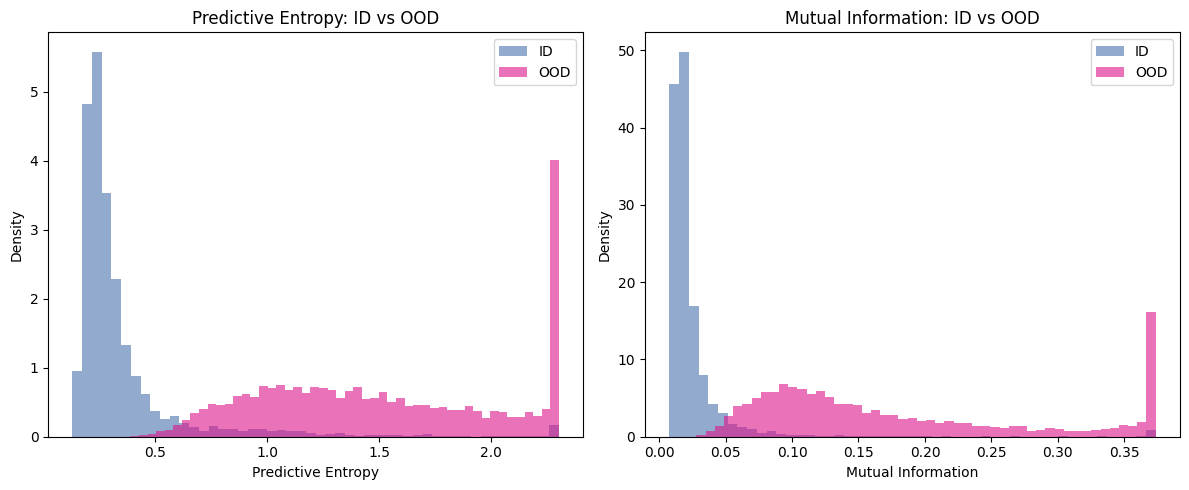

In [45]:
main()